<a href="https://colab.research.google.com/github/ushalvn6/genAIAPP/blob/main/Uplimit_Week0_StudentVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is part of the course: [Building AI products with OpenAI](https://corise.com/go/building-ai-products-with-openai-MWKY3) and is created by Sidharth Ramachandran as the project for this course.

# Summarize & highlight podcast episodes for busy listeners

Welcome to the project that is part of the course - **Building AI products with OpenAI**. In this project, you are going to build an LLM app that summarizes a podcast episode, identifies podcast guests, identifies key highlights and more!

# The Problem

I'm a huge fan of podcasts and love the format as a way to gain deep insights into different industries & technologies and learn from the lived experience of people all over the world. But there is limited time and I end up listening to only some of them! I'm subscribed to several interesting podcasts that release 1-2 episodes a week and the problem is that it's hard to identify an episode that would appeal to me. While many episodes provide show notes, additional links and timestamps, I don't find them very helpful in truly understanding the unique aspects and making me want to listen to it! How can I make this discovery process more interesting and efficient?

# Solution

We would like to generate a personalized newsletter every week that summarizes each podcast episode released in that week. It would include information about the guest on the episode, the main topics discussed as well as some highlights. It would work by collecting a list of RSS feeds from the user and on a periodic basis, process the latest episodes and generate the newsletter. This acts as a round-up of the week, provides the user with the right level of detail that allows them to decide which of the episodes are appealing and must be listened to.

# Approach

We will divide the approach to building this product into three parts -

- Part 1: use a Speech to Text model from OpenAI called Whisper to transcribe the podcast.
- Part 2: use a Large Language Model from OpenAI to build the information extraction functionality to get insights from the podcast.
- Part 3: use chatGPT from OpenAI as your coding assistant to create and deploy a front-end that allows users to experience the end to end functionality

Through this project our aim is to understand how we can approach building and deploying LLM apps that add value to users. We will also provide ideas for interesting extensions and additional functionality at several parts in the project. These are optional but we are excited to see what you might build and showcase in the Demo-Day!

We take care of the necessary imports at the start of this notebook. You can always come back and re-run this specific section in case you want to return to specific sections of the notebook.

In [ ]:
!pip uninstall typing-extensions -y
!pip uninstall gradio -y
!pip install typing_extensions==4.7.1
!pip install gradio
!pip install feedparser
!pip install transformers accelerate
!pip install openai
!pip install tiktoken
!pip install wikipedia

Found existing installation: typing_extensions 4.5.0
Uninstalling typing_extensions-4.5.0:
  Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.7.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

# Part 1 - Podcast Transcription

## Step 1 - Retrieve the audio file

The first step is to get the RSS feed of the podcast, identify the latest episode and retrieve the audio file (typically in MP3 format). One of my favorite websites to find information about podcasts is [ListenNotes](https://www.listennotes.com/). You can search for any podcast you like and then click on the RSS icon to retrieve the RSS feed.

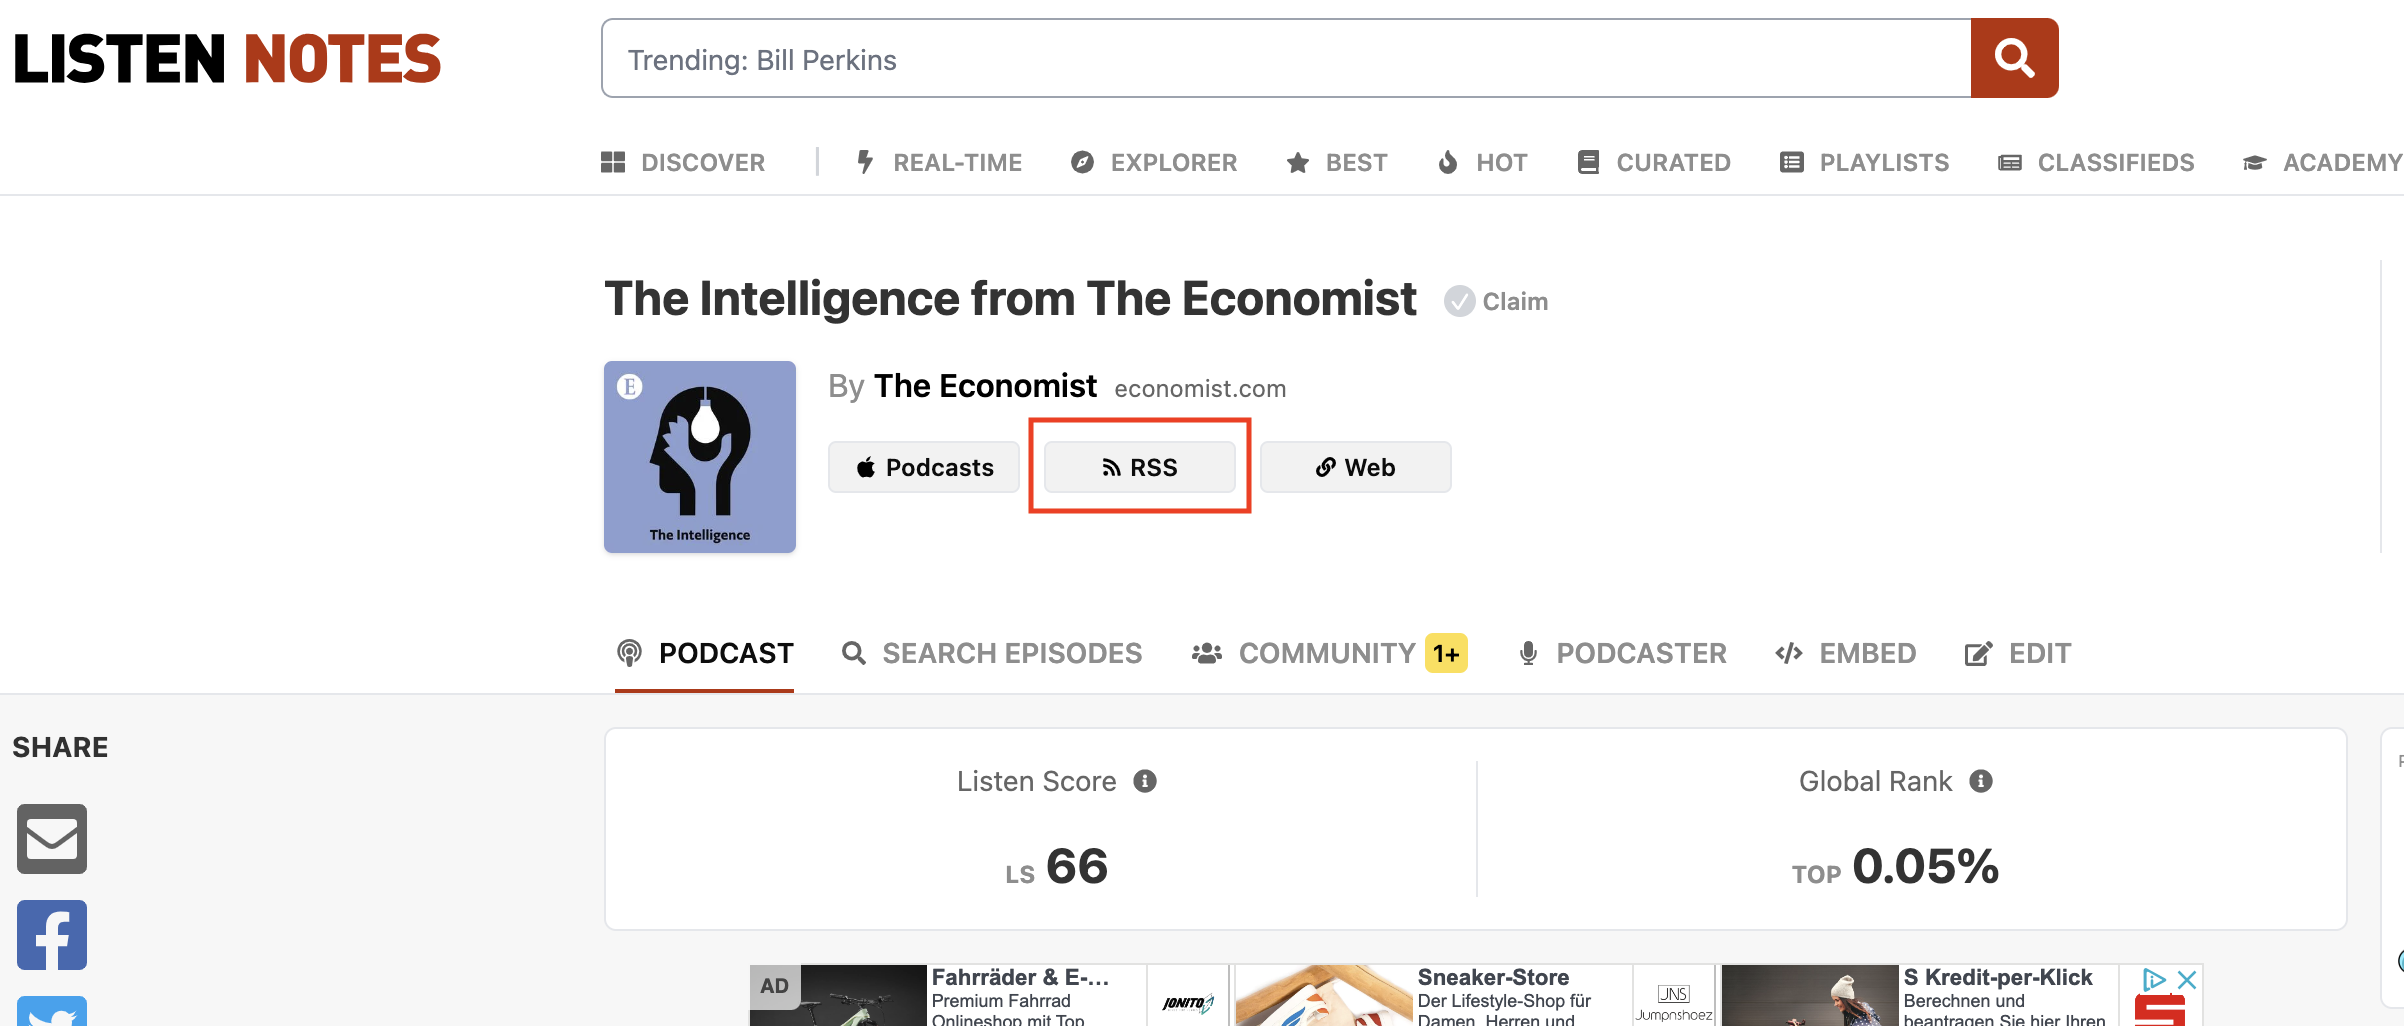

For example, The Economist publishes a daily news roundup podcast called [The Intelligence](https://www.listennotes.com/podcasts/the-intelligence-from-the-economist-the-stZlS3fr8KO/) which is quite concise and informative. Let's use the RSS feed of this podcast.

⚠️⚠️⚠️ ⏭ **IMPORTANT NOTE** ⏮ ⚠️⚠️⚠️

This project works well for podcast episodes that have a run-time between 25-30 minutes. If you choose an episode that is longer in length, you might run into issues with transcription time (since it needs a GPU) and also with the token limit when making calls to OpenAI.

Transcribing longer podcasts is possible and you can add additional checks for token length and split it into multiple API calls to OpenAI. However, this is considered beyond the scope of this project.

👨🏻‍💻📝 **Participant Input Required:** Please enter the RSS feed URL of your selected podcast in the below cell.


---



In [ ]:
import feedparser
podcast_feed_url = "YOUR_PODCAST_RSS_FEED_URL"
podcast_feed = feedparser.parse(podcast_feed_url)

In [ ]:
print ("The number of podcast entries is ", len(podcast_feed.entries))

The number of podcast entries is  1284


Let's get the URL of the most recent episode from the feed and then download the corresponding MP3 file and save it on Google Colab as `podcast_episode.mp3`

In [ ]:
for item in podcast_feed.entries[0].links:
  if (item['type'] == 'audio/mpeg'):
    episode_url = item.href
!wget -O 'podcast_episode.mp3' {episode_url}

--2024-01-08 12:05:51--  https://sphinx.acast.com/p/acast/s/theintelligencepodcast/e/659bd6a8aa30cd0016f8ded5/media.mp3?tk=eyJ0ayI6ImRlZmF1bHQiLCJhZHMiOnRydWUsInNwb25zIjp0cnVlLCJzdGF0dXMiOiJwdWJsaWMifQ==
Resolving sphinx.acast.com (sphinx.acast.com)... 18.154.227.126, 18.154.227.122, 18.154.227.92, ...
Connecting to sphinx.acast.com (sphinx.acast.com)|18.154.227.126|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://stitcher2.acast.com/livestitches/cf6d8102d0b0c7406712db716e72c5f5.mp3?aid=659bd6a8aa30cd0016f8ded5&chid=d556eb54-6160-4c85-95f4-47d9f5216c49&ci=vCKVFA09KWuCEQ3AdDaet3UCHYswsod-LfhDuxzpgvqqbvWxNBuS5A%3D%3D&pf=rss&sv=sphinx%401.194.0&uid=bc3c3e79fb8d0791511d2c7a2b6c8560&Expires=1704727251486&Key-Pair-Id=K38CTQXUSD0VVB&Signature=QSzQqQTi4~t2PDv1r35nlCftDFlBMehfc73AloohlbXk4t~0GGx7ai2zEjXPKc44gihKF2GKTxJxJS5TXOV2XVhPkPYsiRr0XD0OHLVZkYfKBxl6SPqG20K8XzzdxPHlqtxJR11ZCj6YjFw68IatRRHMu~tHQPKfcSHL4k4SazhH8bGBhe3zX9QTVs5Z9vm-c-rvvQfCsLJsg0nVisHL~LPB

To confirm that the podcast episode has been downloaded, you can use the left-hand navigation pane in Google Colab to navigate to the folder section and check.

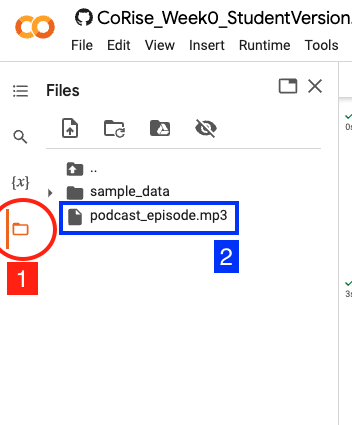

## Step 2 - Transcribe the Audio file

We will use [Distill Whisper](https://huggingface.co/distil-whisper/distil-medium.en) as our speech to text model. The original model has been open-sourced by OpenAI and this version has been distilled (compressed) using additional fine-tuning so that it runs faster. There is a drop in the accuracy but for our use case this will not have a big impact.

In order to make use of HuggingFace, it's necessary to first create an [account](https://huggingface.co/), and agreeing to the Terms & Conditions. Once that is complete then please run the below cell which will provide you with a link to your HuggingFace account where you can copy the token. Once you copy-paste it here then you will be able to pull and use many of the models that are hosted on HuggingFace hub.

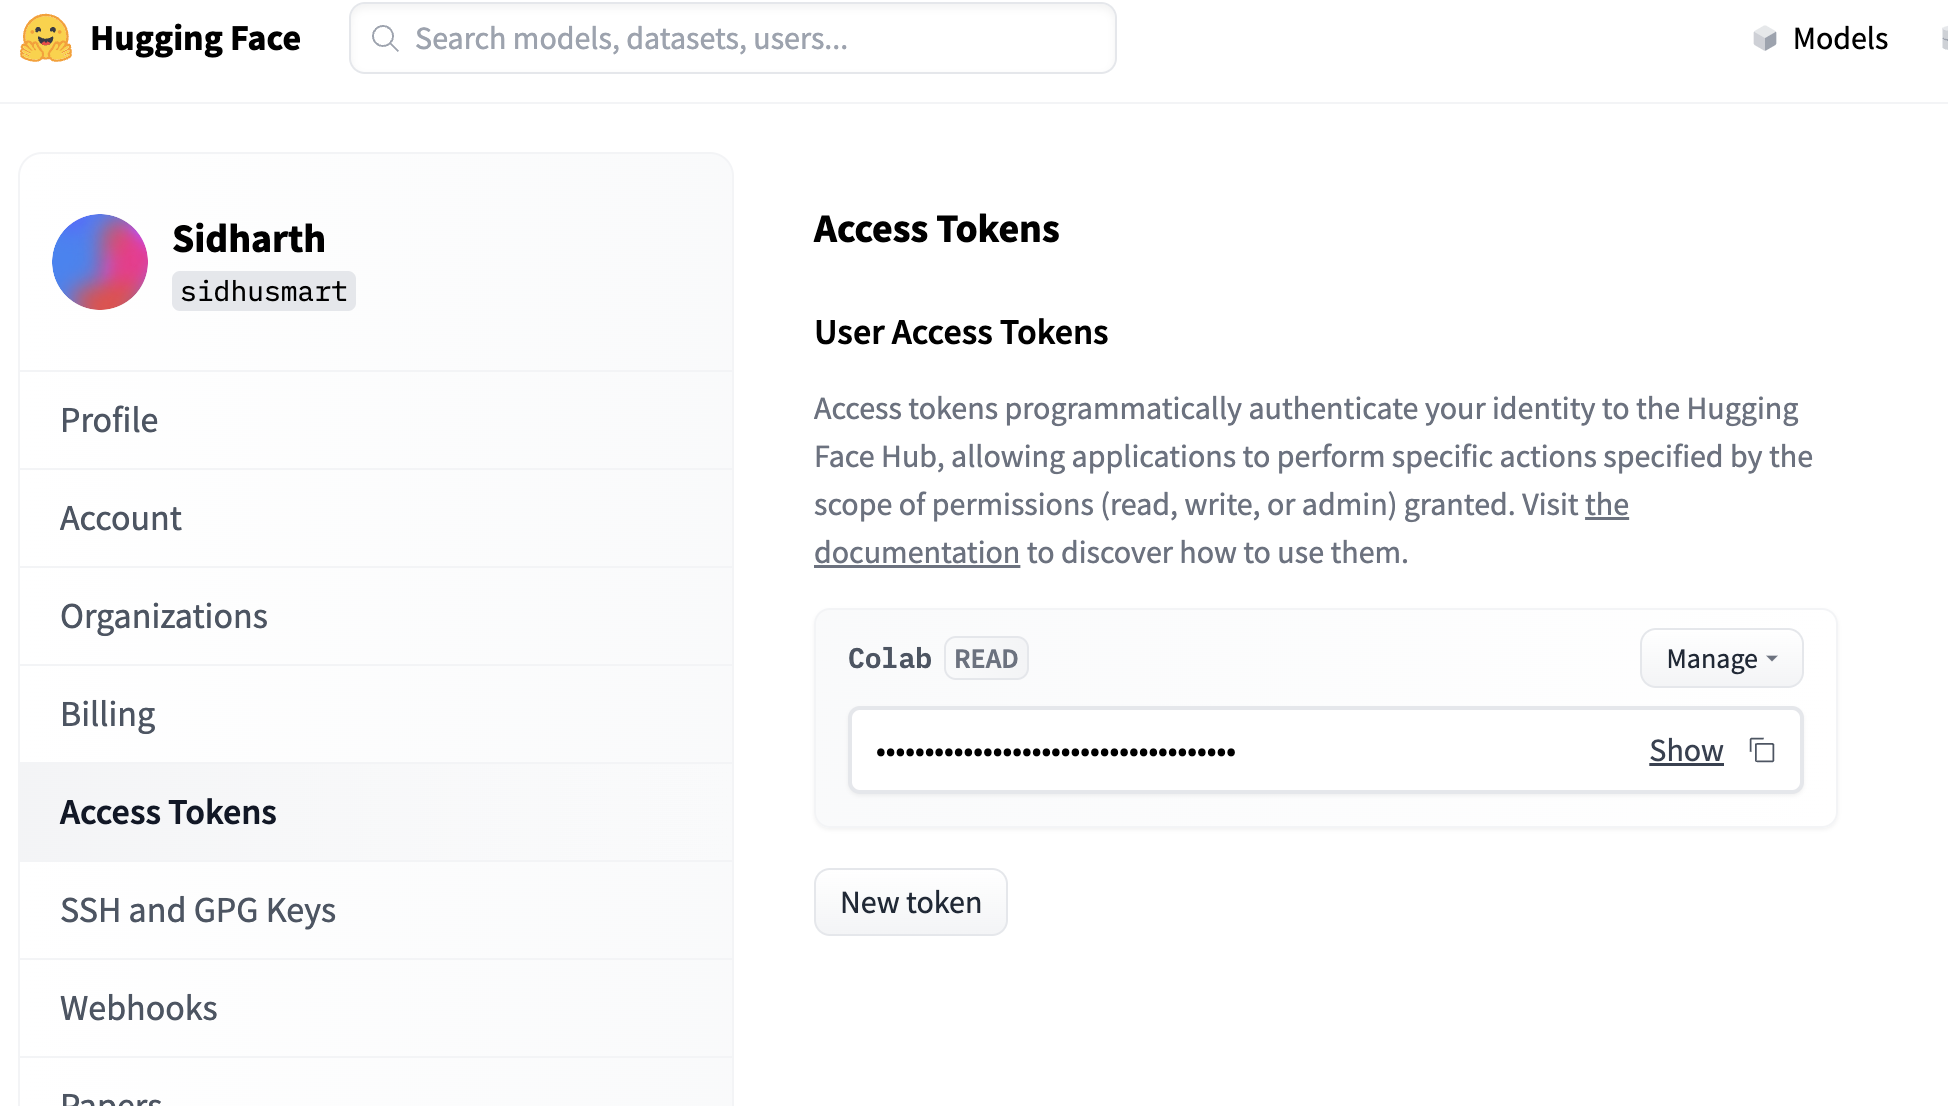

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
%%time

import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "distil-whisper/distil-medium.en"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=15,
    batch_size=16,
    torch_dtype=torch_dtype,
    device=device,
)

config.json:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/789M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


CPU times: user 4.01 s, sys: 2.2 s, total: 6.21 s
Wall time: 18.2 s


Now we need to pass in the location of our downloaded podcast file to get the transcript.

What this model is doing is chunking up the audio into 15 second chunks and then processing 16 of these chunks in one batch. This speeds up the process significantly compared to the original Whisper V2 implementation. This allows us to transcribe a 27 minute podcast in roughly 1 minute!

**NOTE**:
- This step will probably take longer to complete depending on the length of the podcast episode.
- We have created this notebook with the GPU runtime enabled and this will already speed things up. In the free version of Google Colab the notebook will most likely be assigned a T4 GPU which takes roughly a minute to transcribe a 30 minute episode.
- If you have a paid version of Google Colab, you can choose a different GPU like V100 or A100 to speed things up.

In [ ]:
%%time

result = pipe("/content/podcast_episode.mp3")
print(result["text"])

 Where will M&A be at the start of 2024? Listen to Strategic Alternatives, the M&A Podcast series from RBC Capital Markets, to get fresh insights on the driving forces behind M&A activity, the factors that are impacting future deal flow across sectors, and how companies are preparing for a potential surge in M&A activity. Listen and subscribe to Strategic Alternatives, the RBC M&A Podcast today, wherever you get your podcasts. The Economist. Hello and welcome to the intelligence from the economist. I'm Ora Ogunbei. And I'm Jason Palmer. Every weekday we provide a fresh perspective on the events shaping your world. Statistically, Basilden is the most median town in Britain. What does that even mean? Yeah, I wasn't sure either, so we took a trip to the Essex town to find out for ourselves. And for decades after moving to an Israeli kibbutz near the Gaza Strip, Vivian Silver sought the means for peace. The successes of her latest effort, our obituaries editor explains, came just days befo

In [ ]:
# Check the transcription happened correctly by peeking into the first 1000 characters
podcast_transcript = result['text']
result['text'][:1000]

" Where will M&A be at the start of 2024? Listen to Strategic Alternatives, the M&A Podcast series from RBC Capital Markets, to get fresh insights on the driving forces behind M&A activity, the factors that are impacting future deal flow across sectors, and how companies are preparing for a potential surge in M&A activity. Listen and subscribe to Strategic Alternatives, the RBC M&A Podcast today, wherever you get your podcasts. The Economist. Hello and welcome to the intelligence from the economist. I'm Ora Ogunbei. And I'm Jason Palmer. Every weekday we provide a fresh perspective on the events shaping your world. Statistically, Basilden is the most median town in Britain. What does that even mean? Yeah, I wasn't sure either, so we took a trip to the Essex town to find out for ourselves. And for decades after moving to an Israeli kibbutz near the Gaza Strip, Vivian Silver sought the means for peace. The successes of her latest effort, our obituaries editor explains, came just days bef

To avoid being in the situation that the Colab notebook shuts down and you loose the Python variable holding the transcription and to allow for faster testing of subsequent sections, we would recommend you create a local variable that holds your podcast transcript. You can print the contents of `podcast_transcript` from the previous cell and manually assign it to the variable.

This can be very helpful if you are not going through the notebook in one stretch and want to come back to different sections at a later point in time.

In [ ]:
podcast_transcript

👨🏻‍💻📝 **Participant Input Required:** To prevent Colab time-out issues, please copy-paste the generated transcript in the cell below.


---

In [ ]:
podcast_transcript = """
  COPY-PASTE the content of the variable from previous cell to prevent losing the transcript in case of Colab shutdowns
"""

### Extensions

1. Instead of downloading and running the transcription ourselves, you can also use the hosted version of the OpenAI Whisper model (paid). For more details, you can check the [documentation](https://platform.openai.com/docs/models/whisper).
2. The Whisper model does not provide speaker identification but just transcribes what was said. In some situations, it would be good to identify when there are different speakers in the podcast and seperate their dialogues. There are many [libraries](https://github.com/m-bain/whisperX) that work on top of Whisper to enable this.

# Part 2 - Information Extraction

## Step 1 - Creating a summary of the podcast

As part of the information extraction, we would first like to create a summary of the podcast. We want this to be concise while still conveying the gist of the episode and trying to catch the attention of the user. We will use the OpenAI `gpt-3.5-turbo` model to generate this summary by passing in the generated transcript. We are asking the LLM to go through the entire transcript we provide and summarize it for us.

We need to use the `openai` and `tiktoken` libraries. The openai library is the Python package that allows us to make calls to the API. The tiktoken library allows us to determine the number of tokens in our transcript and that gives us an indication of costs and also whether we will need to change the model that we use to one with a larger context window. While we can use the API and make calls directly, it's much easier to work with the Python library provided by OpenAI called - `openai` 🤭.

If you have already performed these steps as part of the Lecture notebook and have the API key, then you can simply proceed to the next step.

Before using the OpenAI API, you need to get an API token. Please create an account with OpenAI by visiting this [link](https://platform.openai.com/) and creating an account with a method of your choice. This will allow us to access the API. Once created, please naviagate to the `Manage Accounts` section of your profile and look-up the `Usage` tab. By default, most new accounts automatically get $5 of credit to try the API and this should be enough for the purposes of this project.

Please also visit the `API Keys` tab and Create a new secret key and copy this and keep it available. We will use this API key in subsequent steps while making the API calls.

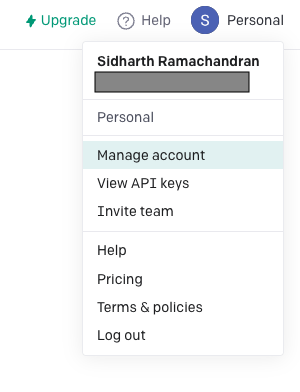

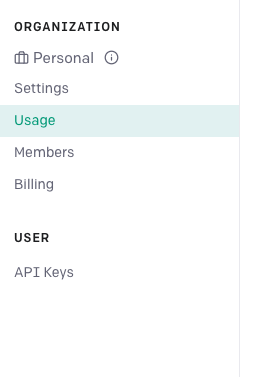

👨🏻‍💻📝 **Participant Input Required:** Please enter your OpenAI key on the Security tab in the left pane of Google Colab as described below.

---

Once you have copied the API key, please click the Security Key icon on the left hand tab of the Google Colab notebook and then add a new parameter value called OPENAI_API_KEY. Here you can provide the API key that you copied and this will not be part of your Google Colab account. You can also enable the toggle `Notebook access` - this will allow your notebook to have access to this API key.

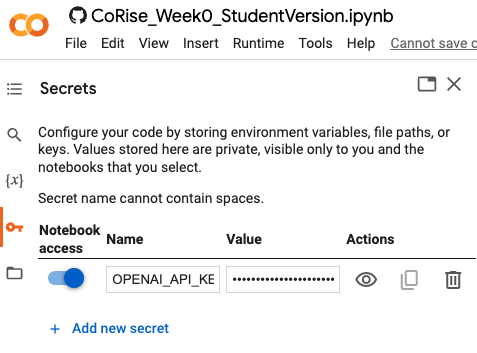

After this, running the following cell will automatically take the API key which will be used for subsequent calls to the OpenAI API.

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

**Context Window**

It's important to understand the concept of a context window. This is the maximum of the combined text that can be used in one API call to the gpt-3.5-turbo model. It is not only a combination of the input text sent to the model but also takes into consideration the output response as well. Also keep in mind that this is measured in terms of tokens and not words. While we could treat them as analogous, it's technically not the same as one word may actually be broken down into multiple tokens.

It's always best to use the tiktoken package to determine the number of tokens in your text.

In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
print ("Number of tokens in input prompt ", len(enc.encode(podcast_transcript)))

Number of tokens in input prompt  5599


As we can see in the case of the Economist podcast episode, this number will typically be higher than the 4096 tokens that is accepted by the default [GPT-3.5-turbo model](https://platform.openai.com/docs/models/gpt-3-5). What it means is that we have to make use of the larger, higher capacity model `gpt-3.5-turbo-16k` that has a context size of 16,384 tokens. Let's use this model to generate the summary for our podcast.

👨🏻‍💻📝 **Participant Input Required:** Please enter the prompt that you would like to use to summarize the podcast in the cell below.


---

In [ ]:
instructPrompt = """
YOUR_PROMPT_HERE
"""

request = instructPrompt + podcast_transcript

In [ ]:
chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [ ]:
podcastSummary = chatOutput.choices[0].message.content
podcastSummary

## Step 2 - Using `functions` to extract additional information to provide additional context on the episode

We can provide additional context to the listener about a certain episode if we are able to identify the guest and add a summary of their background and experience.

We can easily find information about the guest using Wikipedia or Google but first we also need to extract the name of the podcast guest. Since we are looking to pass the extracted name of the podcast guest to a subsequent function, we need to ensure that the output we recieve from the API is as structured as possible.

To achieve this, we are going to make use of the recently released `function calling` capability of the OpenAI API that we already introduced in the Lecture session and notebook. Please refer to that notebook for more information.

- The way to achieve this is by defining a function with very clear information on what it expects and in which format. This is specified as a separate input to the chat completion endpoint as you see below.
- Typically in a podcast episode the guest will be introduced in the first half and therefore it's not necessary to use the entire transcript to extract this information.
- We pass in only the first 5000 characters and this will save us token usage as well and therefore we can use the non 16k model.

In [ ]:
request = podcast_transcript[:5000]
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
print ("Number of tokens in input prompt ", len(enc.encode(request)))

👨🏻‍💻📝 **Participant Input Required:** Please enter the description of the function and the variable at the appropriate points below.

---



In [ ]:
completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": request}],
    functions=[
    {
        "name": "get_podcast_guest_information",
        "description": "ADD_THE_FUNCTION_DESCRIPTION_HERE",
        "parameters": {
            "type": "object",
            "properties": {
                "guest_name": {
                    "type": "string",
                    "description": "ADD_THE_VARIABLE_DESCRIPTION_HERE",
                },
                "unit": {"type": "string"},
            },
            "required": ["guest_name"],
        },
    }
    ],
    function_call={"name": "get_podcast_guest_information"}
    )

We can directly see how the output from the API is formatted by checking the response object `completion`

In [ ]:
completion

It looks like the output is formatted with JSON and in a structured way that allows us to use this output directly.

In [ ]:
import json

podcast_guest = ""
response_message = completion.choices[0].message
if response_message.function_call:
  function_name = response_message.function_call.name
  function_args = json.loads(response_message.function_call.arguments)
  podcast_guest=function_args.get("guest_name")

print ("Podcast Guest is ", podcast_guest)

### Extensions

1. Sometimes it's possible that guest extraction may happen partially or not at all. We can still attempt to find more information about the podcast guest by extracting additional information about them like their organization or title.
2. Depending on the podcast and generated transcript, it's also possible that extraction is incorrect and we need to include error handling for these conditions.
3. In order to find more infromation about the guest, you could consider extracting this information from external APIs like Wikipedia, Google Search or Databases like Crunchbase depending on your use-case.

#### Extension Solution 1

Let's consider the case where podcast guest name may not be enough OR it has not been extracted well or completely. One way to resolve this would be to extract additional information:

- Podcast Guest Organization
- Podcast Guest Title

You can also adjust the prompt to say that we would like to extract the `full name` of the podcast guest. This helps the model understand our intention better. We can also provide more context by including the larger portion (first 10k characters) from the start of the podcast transcript as that's where organization, title and such details might be covered during their introduction.

Let's see what this function looks like.

In [ ]:
request = podcast_transcript[:10000]
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
print ("Number of tokens in input prompt ", len(enc.encode(request)))

In [ ]:
completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": request}],
    functions=[
    {
        "name": "get_podcast_guest_information",
        "description": "Get information on the podcast guest using their full name and the name of the organization they are part of to search for them on Wikipedia or Google",
        "parameters": {
            "type": "object",
            "properties": {
                "guest_name": {
                    "type": "string",
                    "description": "The full name of the guest who is speaking in the podcast",
                },
                "guest_organization": {
                    "type": "string",
                    "description": "The full name of the organization that the podcast guest belongs to or runs",
                },
                "guest_title": {
                    "type": "string",
                    "description": "The title, designation or role of the podcast guest in their organization",
                },
            },
            "required": ["guest_name"],
        },
    }
],
function_call={"name": "get_podcast_guest_information"}
)

In [ ]:
import json

podcast_guest = ""
podcast_guest_org = ""
podcast_guest_title = ""
response_message = completion.choices[0].message
if response_message.function_call:
  function_name = response_message.function_call.name
  function_args = json.loads(response_message.function_call.arguments)
  podcast_guest=function_args.get("guest_name")
  podcast_guest_org=function_args.get("guest_organization")
  podcast_guest_title=function_args.get("guest_title")

In [ ]:
print (podcast_guest)
print (podcast_guest_org)
print (podcast_guest_title)

Let's consider that we use Wikipedia to search for a page that lists more information about the guest of the show.

In [ ]:
if podcast_guest_org is None:
  podcast_guest_org = ""
if podcast_guest_title is None:
  podcast_guest_title = ""

In [ ]:
import wikipedia

input = wikipedia.page(podcast_guest + " " + podcast_guest_org + " " + podcast_guest_title, auto_suggest=True)

In [ ]:
input.summary

## Step 3: Extract the highlights of the podcast

We've provided our reader with a summary of the podcast and more information about the guest on this episode. What if we could also give them a peak into the conversation?

In this step, we want to extract some key moments in the podcast. These are typically interesting insights from the guest or critical questions that the host might have put forward. It could also be a discussion on a hot topic or controversial opinion.  

👨🏻‍💻📝 **Participant Input Required:** Please enter the prompt that you would use to extract the highlights of the podcast in the cell below.

---

In [ ]:
instructPrompt = """
YOUR_PROMPT_HERE
"""

request = instructPrompt + podcast_transcript

In [ ]:
chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [ ]:
chatOutput.choices[0].message.content

In [ ]:
podcastHighlights = chatOutput.choices[0].message.content

### Extensions

There are additional pieces of information that you might choose to extract like
    - the key topics that are being discussed in the episode
    - extract the timestamp along with the highlights so that a user could navigate directly to the location in the podcast where that discussion happens
    - build chapters of the podcast and identify their title


In the previous section we saw that we are able to use the OpenAI API to extract the required information rather easily, the output is delivered in a structured way allowing us to call downstream APIs and much more. This shows us that we could possibly build a product in this direction.

## Step 4: Defining information extraction steps as functions

So far, we have been testing the OpenAI API and prompts to extract information from the podcast episode. This is an interactive style of programming when starting to work on a problem and figuring out whether the approach makes sense. As we become more confident of our solution, it makes sense to modularise the logic and prompts into separate functions to make our code robust and easily repeatable/callable from other parts of our code.

This is especially important at this stage of the project as we want to create a front-end and would like to call the information extraction functions that will serve as the back-end.

In the below sections, we gather all the information extraction steps that we experimented with so far into clearly defined functions. We will create a `process_podcast` function that carries out a series of steps starting from podcast transcription, followed by summarization, podcast guest extraction and identifying highlights. You can imagine this to be our workflow.

We start by defining the function `download_podcast_episode` that takes in the RSS feed and downloads the latest podcast episode as an MP3 file.

In [ ]:
import os

def download_podcast_episode(rss_url, local_path="/content/"):
  print ("Starting Podcast Transcription Function")
  print ("Feed URL: ", rss_url)

  # Read from the RSS Feed URL
  import feedparser
  intelligence_feed = feedparser.parse(rss_url)
  podcast_title = intelligence_feed['feed']['title']
  episode_title = intelligence_feed.entries[0]['title']
  episode_image = intelligence_feed['feed']['image'].href
  for item in intelligence_feed.entries[0].links:
    if (item['type'] == 'audio/mpeg'):
      episode_url = item.href
  episode_name = "podcast_episode.mp3"
  print ("RSS URL read and episode URL: ", episode_url)

  # Setup the path variable
  from pathlib import Path
  p = Path(local_path)
  p.mkdir(exist_ok=True)

  # Download the latest podcast episode
  print ("Downloading the podcast episode")
  import requests
  with requests.get(episode_url, stream=True) as r:
    r.raise_for_status()
    episode_path = p.joinpath(episode_name)
    with open(episode_path, 'wb') as f:
      for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

  print ("Podcast Episode downloaded")
  return episode_path, podcast_title, episode_title, episode_image

Next, we define the transcription function - `transcribe_podcast_episode` that uses the Distill Whisper model to transcribe the podcast episode.

In [ ]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

def transcribe_podcast_episode(episode_path):
  # Run the transcription process
  print (episode_path)
  processor = AutoProcessor.from_pretrained(model_id)

  pipe = pipeline(
      "automatic-speech-recognition",
      model=model,
      tokenizer=processor.tokenizer,
      feature_extractor=processor.feature_extractor,
      max_new_tokens=128,
      chunk_length_s=15,
      batch_size=16,
      torch_dtype=torch_dtype,
      device=device,
  )

  result = pipe("/content/podcast_episode.mp3")
  podcast_transcript = result["text"]
  print ("Podcast Transcription Completed")
  return podcast_transcript

Finally we add all the information extraction functions - `get_podcast_summary`, `get_podcast_guest` and `get_podcast_highlights` which each make calls to the OpenAI LLM.

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def get_podcast_summary(podcast_transcript):
  instructPrompt = """
  You are an expert copywriter who is responsible for publishing newsletters with thousands of subscribers. You recently listened to a great podcast
  and want to share a summary of it with your readers. Please write the summary of this podcast making sure to cover the important aspects that were
  discussed and please keep it concise.
  The transcript of the podcast is provided below.
  """
  request = instructPrompt + podcast_transcript
  chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )
  podcastSummary = chatOutput.choices[0].message.content
  return podcastSummary

def get_podcast_guest(podcast_transcript):
  import wikipedia
  import json
  request = podcast_transcript[:10000]
  completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": request}],
    functions=[
    {
        "name": "get_podcast_guest_information",
        "description": "Get information on the podcast guest using their full name and the name of the organization they are part of to search for them on Wikipedia or Google",
        "parameters": {
            "type": "object",
            "properties": {
                "guest_name": {
                    "type": "string",
                    "description": "The full name of the guest who is speaking in the podcast",
                },
                "guest_organization": {
                    "type": "string",
                    "description": "The full name of the organization that the podcast guest belongs to or runs",
                },
                "guest_title": {
                    "type": "string",
                    "description": "The title, designation or role of the podcast guest in their organization",
                },
            },
            "required": ["guest_name"],
        },
    }],
    function_call={"name": "get_podcast_guest_information"})
  response_message = completion.choices[0].message

  # Extract the relevant information
  podcast_guest = ""
  podcast_guest_org = ""
  podcast_guest_title = ""

  if response_message.function_call:
    function_name = response_message.function_call.name
    function_args = json.loads(response_message.function_call.arguments)
    podcast_guest=function_args.get("guest_name")
    podcast_guest_org=function_args.get("guest_organization")
    podcast_guest_title=function_args.get("guest_title")

  if (podcast_guest is not None):
    if (podcast_guest_org is None):
      podcast_guest_org = ""
    if (podcast_guest_title is None):
      podcast_guest_title = ""
    try:
        input = wikipedia.page(podcast_guest + " " + podcast_guest_org + " " + podcast_guest_title, auto_suggest=True)
        podcast_guest_summary = input.summary
    except wikipedia.exceptions.PageError:
        print(f'The page for guest "{podcast_guest}" does not exist on Wikipedia.')
        podcast_guest_summary = "Not Available"
    except wikipedia.exceptions.DisambiguationError as e:
        print(f'The page for guest "{podcast_guest}" is ambiguous. Possible matches are:')
        print(e.options)
        podcast_guest_summary = "Not Available"
  else:
    podcast_guest = "Not Available"
    podcast_guest_org = "Not Available"
    podcast_guest_title = "Not Available"
    podcast_guest_summary = "Not Available"

  podcastGuest = {}
  podcastGuest['name'] = podcast_guest
  podcastGuest['org'] = podcast_guest_org
  podcastGuest['title'] = podcast_guest_title
  podcastGuest['summary'] = podcast_guest_summary
  return podcastGuest

def get_podcast_highlights(podcast_transcript):
  instructPrompt = """
  You are a podcast editor and producer. You are provided with the transcript of a podcast episode and have to identify the 5 most significant moments in the podcast as highlights.
  - Each highlight needs to be a statement by one of the podcast guests
  - Each highlight has to be impactful and an important takeaway from this podcast episode
  - Each highlight must be concise and make listeners want to hear more about why the podcast guest said that
  - The highlights that you pick must be spread out throughout the episode

  Provide only the highlights and nothing else. Provide the full sentence of the highlight and format it as follows -

  - Highlight 1 of the podcast
  - Highlight 2 of the podcast
  - Highlight 3 of the podcast
  """
  request = instructPrompt + podcast_transcript
  chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )
  podcastHighlights = chatOutput.choices[0].message.content
  return podcastHighlights

Finally, we create the `process_podcast` function that defines the entire pipeline and provides us the output in a dictionary file.

In [ ]:
def process_podcast(url):
  output = {}
  podcast_episode_path, podcast_title, episode_title, episode_image = download_podcast_episode(url)
  podcast_transcription = local_transcribe_podcast_episode(podcast_episode_path)
  podcast_summary = get_podcast_summary(podcast_transcription)
  podcast_guest = get_podcast_guest(podcast_transcription)
  podcast_highlights = get_podcast_highlights(podcast_transcription)
  output['podcast_title'] = podcast_title
  output['episode_title'] = episode_title
  output['episode_image'] = episode_image
  output['podcast_summary'] = podcast_summary
  output['podcast_guest'] = podcast_guest
  output['podcast_highlights'] = podcast_highlights
  output['podcast_transcription'] = podcast_transcription
  return output

As a way to test the entire process, we can call it directly with a podcast RSS URL of your choice.

⚠️⚠️⚠️ ⏭ **IMPORTANT NOTE** ⏮ ⚠️⚠️⚠️

As noted in Part 1, please make sure that any podcast you choose has episodes in the 25-30 minute range.

In [ ]:
%%time
# Let's test our entire podcast process
out = process_podcast("https://feeds.megaphone.fm/HS6260485755")

As an additional helper function, we can save the produced podcast summaries and other information into a JSON file that can be retrieved by the front-end.

In [ ]:
import json
with open("/content/podcast-1.json", "w") as outfile:
  json.dump(out, outfile)

Since we are building a front-end app in the next section, we don't want to be waiting for 5 mins for the details of our podcast to load. So you can repeat this process for multiple podcasts of your choice to create a pre-defined list for your front-end. This is useful to pre-populate the app with existing summaries to show the user what kind of information can be extracted and provide some samples.

Please make sure to change the variable names of the podcast JSON. We choose to use podcast-1.json, podcast-2.json and so on.   

In [ ]:
%%time

import json
def create_podcast_json(podcast_name, podcast_feed_url):
  out = process_podcast(podcast_feed_url)
  with open("/content/" + podcast_name + ".json", "w") as outfile:
    json.dump(out, outfile)

# Let's test our entire podcast process
podcast_feed_url = "https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49"
podcast_name = "podcast-2"
create_podcast_json(podcast_name, podcast_feed_url)

# Part 3 - Creating a front-end application

In the final part of our AI product let's create a front-end for our podcast summarizer application. Since we want to create our product as a weekly newsletter, it's not necessary to have a front-end but this can help our users visualize what the newsletter looks like. It also gives them an opportunity to play around with their choice of RSS feeds.

Since we want to keep it simple we choose to go with a Gradio application for our front-end. We can stick with Python as the programming language and also deploying and sharing the link is easy!

## Step 1 - Use ChatGPT as your programming buddy!

In this step, we want to help you discover how one can use ChatGPT (the free web version) as a programming buddy to fulfill this task. As you will discover, it's an easy way to get started with boilerplate code and also request customizations as we go along.

The instructor will go through the steps on how to use ChatGPT and what to be careful about when doing so in the Project kick-off session. In the end we hope to create a nice web interface.

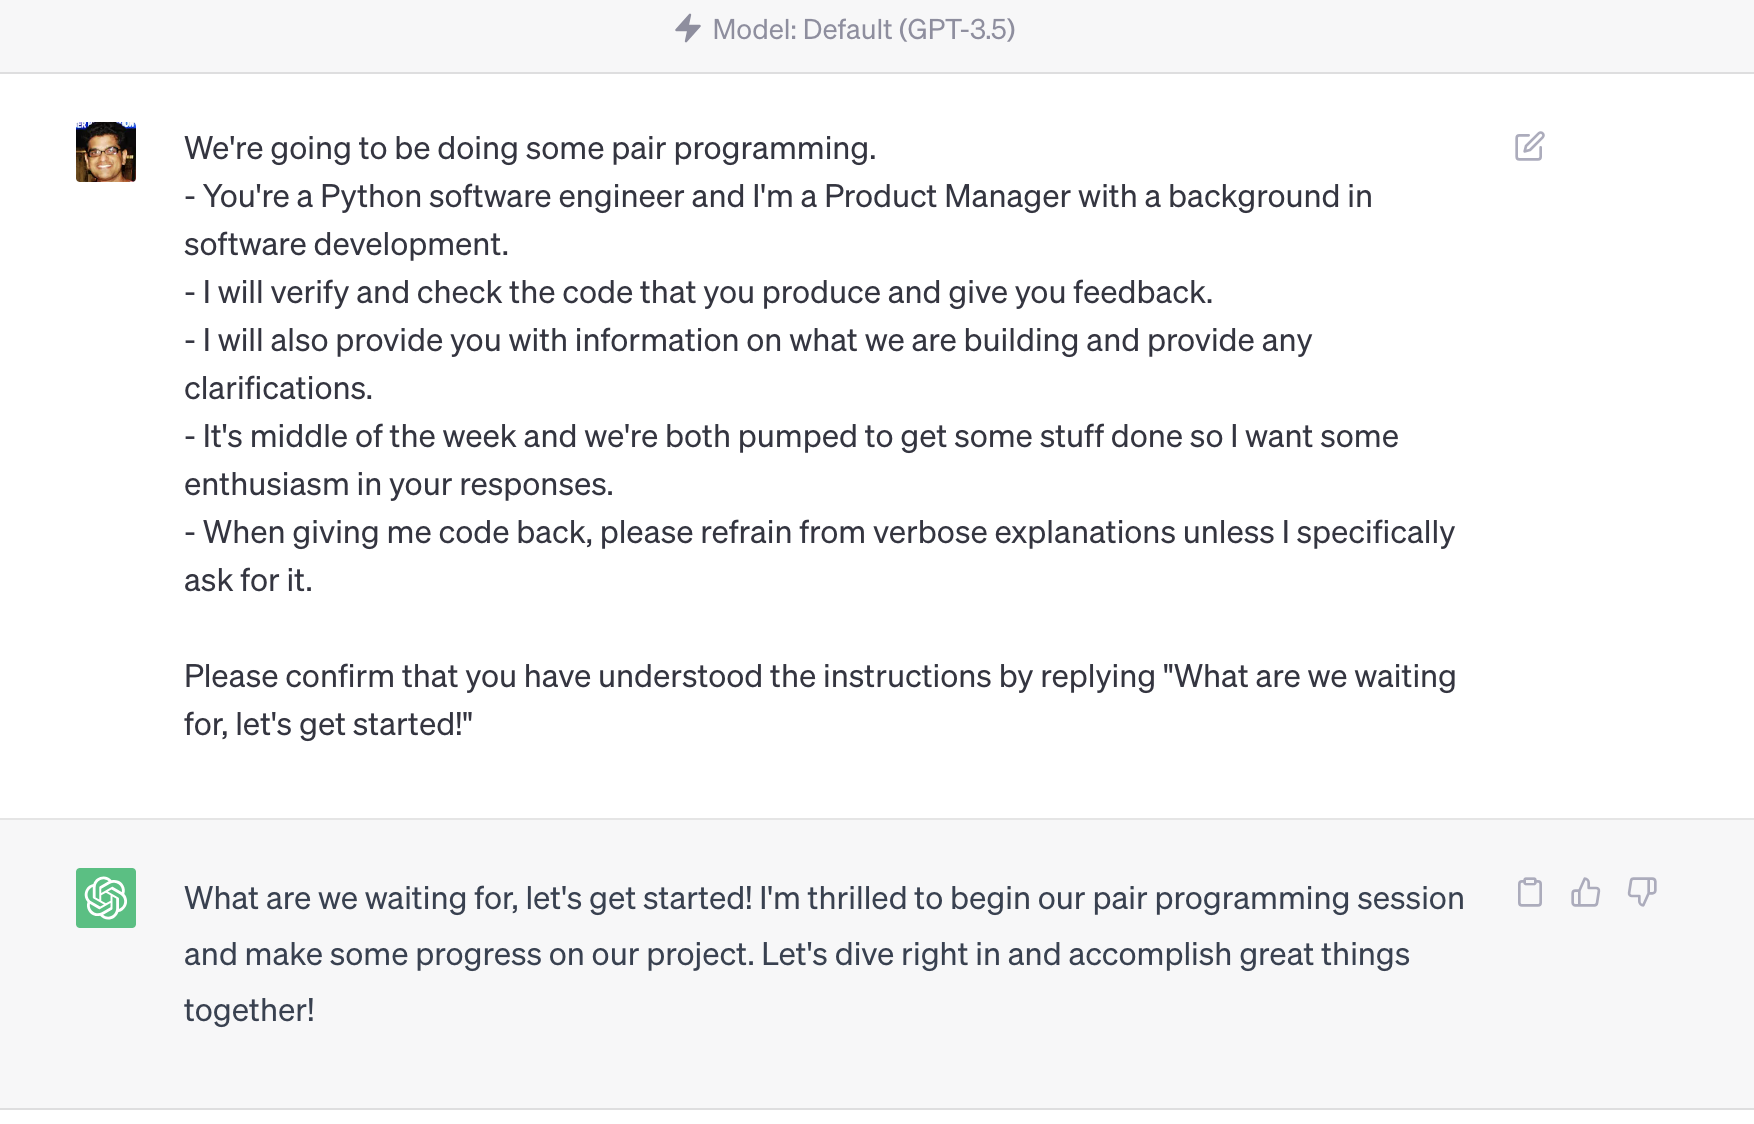

## Step 2 - Creating a Gradio front-end that displays the podcast information

We hope that you enjoyed the pair programming exercise with ChatGPT. Hopefully it went well and you have a final version of how the web front-end looks like which we will display using a Gradio app.

We first define a function that loads in all the existing JSON files containing the podcast information. This is to ensure that we can populate the web app with existing information about our favorite podcasts that we have already processed.

In [ ]:
import os
import json

def create_dict_from_json_files(folder_path):
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    data_dict = {}

    for file_name in json_files:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            podcast_info = json.load(file)
            podcast_name = podcast_info['podcast_title']
            # Process the file data as needed
            data_dict[podcast_name] = podcast_info

    return data_dict

In [ ]:
available_podcast_info = create_dict_from_json_files('/content/')

In the next step, we create the function that will populate the information about the podcast and return the HTML for our web front-end. The HTML should reflect the web-app that you designed in the previous step with ChatGPT but we provide a simple one here for you to use as well.

In [ ]:
def generate_podcast_episode_html(podcast_info):
    title = podcast_info['podcast_title']
    summary = podcast_info['podcast_summary']
    image_src = podcast_info['episode_image']
    guest = podcast_info['podcast_guest']['name']
    highlight = podcast_info['podcast_highlights']
    # Define the HTML content as a string with placeholders for variables
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>{title}</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                background-color: #f5f5f5;
                margin: 0;
                padding: 0;
            }}

            .container {{
                max-width: 960px;
                margin: 0 auto;
                padding: 20px;
            }}

            .episode-title {{
                font-size: 24px;
                font-weight: bold;
                margin-bottom: 20px;
            }}

            .episode-summary {{
                margin-bottom: 20px;
            }}

            .episode-image {{
                width: 100%;
                max-width: 100%;
                height: auto;
            }}

            .episode-highlights,
            .episode-guest {{
                margin-top: 20px;
            }}

            .episode-highlights h2,
            .episode-guest h2 {{
                font-size: 18px;
                font-weight: bold;
                margin-bottom: 10px;
            }}

            ul {{
                list-style-type: disc;
                margin-left: 20px;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1 class="episode-title">{title}</h1>
            <div class="episode-summary">
                <p>
                    {summary}
                </p>
            </div>
            <img class="episode-image" src="{image_src}" alt="{title}">
            <div class="episode-highlights">
                <h2>Podcast Highlights</h2>
                <ul>
                    {highlight}
                </ul>
            </div>
            <div class="episode-guest">
                <h2>Podcast Guest</h2>
                <p>
                    {guest}
                </p>
            </div>
        </div>
    </body>
    </html>
    """

    return html_content

In the next step, we define two functions that will be called by the two buttons we have in our app. The first will be used to select a podcast from the drop-down list and show all the summarized information.

The second one will be used to accept an RSS feed URL as the input and then process the podcast to generate the summarized information.

In [ ]:
def show_podcast_info(podcast_name):
  podcast_info = available_podcast_info[podcast_name]
  return generate_podcast_episode_html(podcast_info)

def process_podcast_info(rss_url):
  podcast_info = process_podcast(rss_url)
  return generate_podcast_episode_html(podcast_info)

Finally, we care the gradio app that runs our application. You will notice that it runs within this notebook but you can also share it via the provided URL to other users and it will display the complete app to anyone.

In [ ]:
import gradio as gr

with gr.Blocks() as demo:
    podcast_name = gr.Dropdown(available_podcast_info.keys(), label="podcast_name")
    show_podcast_button = gr.Button("Show Podcast Summary")
    podcast_url = gr.Textbox(label="podcast_url")
    process_podcast_button = gr.Button("Process Podcast")
    output= gr.HTML(label="podcast_info")
    show_podcast_button.click(fn=show_podcast_info, inputs=podcast_name, outputs=output, api_name="show_podcast_info")
    process_podcast_button.click(fn=process_podcast_info, inputs=podcast_url, outputs=output, api_name="process_podcast_info")

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2cff01fdf90b9aee4f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Starting Podcast Transcription Function
Feed URL:  https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49
RSS URL read and episode URL:  https://sphinx.acast.com/p/acast/s/theintelligencepodcast/e/659bd6a8aa30cd0016f8ded5/media.mp3?tk=eyJ0ayI6ImRlZmF1bHQiLCJhZHMiOnRydWUsInNwb25zIjp0cnVlLCJzdGF0dXMiOiJwdWJsaWMifQ==&sig=NdTxutgIPXSgJKs9VTv3BH_ivDJrXrhMsQYItc_I6AE
Podcast Episode downloaded
/content/podcast_episode.mp3
Loading data..


# Part 4: Using free and local alternatives

In this section, we present alternative LLM and Transcription options that can run locally. This will obviously have longer processing times but you will not be charged credits for using an API. Please note that this approach is experimental and will be more variable in terms of quality of output and speed. The libraries and tools are experimental in nature and can change at short notice. Our recommendation would be to stick with the default options presented above for a simple approach.

But we do present these options that you can run for free within a Colab notebook. This is an alternative way of completing the project for those who have run out of credits on OpenAI or do not want to attach a credit card for any reason.



### **LLAMA-CPP**

In order to run a local LLM, we will make use of the [Llama-CPP-Python package](https://github.com/abetlen/llama-cpp-python). In addition to OpenAI and Claude that are closed source models accecible only through an API, there are several open-source language models that are primarily derived from [LLAMA-2](https://ai.meta.com/llama/) (from Meta) or [Mistral](https://mistral.ai/news/announcing-mistral-7b/). Since they are open-source, the community has fine-tuned on multiple datasets and created several versions that serve various purposes.

These models come in different sizes starting from a 7 Billion parmaeter model going upto 70 billion parameters. Even still, they are quite large and take up quite some GPU RAM when loaded. As a result, there is an initiative to quantize these models and provide them in C++ binaries that are much smaller in size and can easily fit into memory. On the other hand, they do loose some quality and can still take long to generate responses.

We start by installing the llama-cpp-python library with some additional options that make sure that we are using the GPU version that can leverage the T4 GPU available for free on Google Colab.

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python

Most of the quantized models are made available by a handle called [TheBloke](https://huggingface.co/TheBloke) on HuggingFace. They are available in multiple quantized format and we will not go into depth but suffice to say that we choose a version that can be loaded in memory and produces reasonable output.

For our project, we would recommend running the WizardLM-13B model that is currently rated high in the OpenLLM Chatbot [leaderboard](https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard). The code below downloads the WizardLM 13 Billion parameter model and stores it within the Google Colab directory.

In [ ]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="TheBloke/WizardLM-13B-V1.2-GGUF", filename="wizardlm-13b-v1.2.Q4_K_S.gguf", local_dir='/content')

In the following step, we are loading the downloaded model into GPU memory and setup some parameters like the context window, temperature etc. You can vary these based on your preferences but we have provided the recommended defaults.

In [ ]:
from llama_cpp import Llama
n_gpu_layers = 40 # Change this value based on your model and your GPU VRAM pool.
llm = Llama(model_path="/content/wizardlm-13b-v1.2.Q4_K_S.gguf",
            temperature=0.75,
            max_tokens=6000,
            top_p=1,
            verbose=True,
            n_gpu_layers=n_gpu_layers,
            n_ctx=6000
)

### Creating a summary of the podcast with a local LLM

The great thing about the llama-cpp-python library is that it provides very similar APIs to those provided by OpenAI. So the code for actually making the LLM call, should look very familiar to the original example provided above. The only change we make is to take only a part of the transcript since the context window of the local LLM is not as large as the 16k context window provided by GPT-3.5-Turbo.

In [ ]:
instructPrompt = """
You are an expert copywriter who is responsible for publishing newsletters with thousands of subscribers. You recently listened to a great podcast
and want to share a summary of it with your readers. Please write the summary of this podcast making sure to cover the important aspects that were
discussed and please keep it concise.
The transcript of the podcast is provided below.
"""

request = instructPrompt + podcast_transcript[0:2500]

In [ ]:
%%time
chatOutput = llm.create_chat_completion(messages = [{"role": "system", "content": "You are a helpful assistant"},
                                                    {"role": "user", "content": request}
                                                   ]
                                       )

In [ ]:
podcastSummary = chatOutput['choices'][0]['message']['content']
podcastSummary

As you can see above, the local LLAMA based model also generates a reasonable summary based on the podcast transcript. It takes about 2 minutes for each call and we also had to truncate the podcast transcript to ensure that we fit within the context window. These restrictions can be overcome by smaller models or if you have access to a larger and better GPU.

## WHISPER-CPP

In this section we try to use a CPP version of Whisper that has been quantized to run with just a CPU. It takes longer to run through a transcription but gives you the opportunity to deploy a host your app in HuggingFace spaces without the need for paying for a GPU.

In [ ]:
!pip install git+https://github.com/stlukey/whispercpp.py

  Cloning https://github.com/stlukey/whispercpp.py to /tmp/pip-req-build-kr5hl2xa
  Running command git clone --filter=blob:none --quiet https://github.com/stlukey/whispercpp.py /tmp/pip-req-build-kr5hl2xa
  Resolved https://github.com/stlukey/whispercpp.py to commit 7af678159c29edb3bc2a51a72665073d58f2352f
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for whispercpp: filename=whispercpp-1.0-cp310-cp310-linux_x86_64.whl size=2296563 sha256=c5a1ba6c4c8da2981632149c3a6ec433669b527ec5d123616379f9aeabad3d2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-syncxgjp/wheels/66/a1/a8/e5b342b3d6d1b65b787546ee9d5a1d948c8ab3db3c879d7df1
Successfully built whispercpp


We define an alternate transcription function called `local_transcribe_podcast_episode` as shown below. This takes approximately 7 mins to transcribe a 30 min episode compared to 1 min taken by the GPU version presented above. If you would like to use this function in your app, then you only need to replace the older transcription function with this one.

In [ ]:
from whispercpp import Whisper

def local_transcribe_podcast_episode(episode_path):
  # Run the transcription process
  print (episode_path)
  w = Whisper('tiny')

  result = w.transcribe("/content/podcast_episode.mp3")
  text = w.extract_text(result)
  podcast_transcript = ''.join(text)
  print ("Podcast Transcription Completed")
  return podcast_transcript

In [ ]:
%%time

transcript = local_transcribe_podcast_episode("/content/podcast_episode.mp3")
print (transcript)